Copyright 2025 Tsung-Tang Lee (also known as Osborn Lee or Moe)

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

特別聲明： 禁止修改本程式碼後，聲稱為自己原創或作者。 修改後的作品必須保留原作者資訊

In [ ]:
import os
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

In [ ]:
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.19.0
Num GPUs Available: 1


In [ ]:
!nvidia-smi

Sun Jul 20 08:14:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   66C    P8             12W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
batch_size = 128
num_classes = 10
epochs = 100
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# one-hot encoding
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# build CNN model
model = Sequential([
    Conv2D(64, (3, 3), padding='same',input_shape=x_train.shape[1:]),
    Activation('relu'),
    Conv2D(128, (3, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), padding='same'),
    Activation('relu'),
    Conv2D(64, (3, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(512),
    Activation('relu'),
    Dropout(0.5),
    Dense(num_classes),
    Activation('softmax')
])

print(model.summary())

# initiate Adam optimizer
opt = Adam()

# train model by optimizer Adam
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.


print('data augmentation')
# Tpreprocessing : data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,    # 訓練前，會被隨機旋轉 ±30 度之間的某個角度
    width_shift_range=0.1,  # 每張圖片在訓練前，會被隨機水平平移 ±10% 圖片寬度的距離
    height_shift_range=0.1,  # 每張圖片在訓練前，會被隨機上下平移 ±10% 圖片高度的距離
    horizontal_flip=True,   # 訓練時，每張圖片有機會被隨機水平翻轉（左右翻轉）
    vertical_flip=False)   # 在資料增強時，不執行垂直翻轉（上下顛倒）的操作

# Use ModelCheckpoint to save the best performance model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)

# earlystop
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Model fit
model_history = model.fit(datagen.flow(x_train, y_train,
                    batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks=[earlystop, checkpoint],
                    )

# loading saved model that trained below
print("Loading trained model")
model = load_model(model_path)

# Score trained model by accuracy and loss
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 30, 30, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 15, 15, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 13, 13, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         5,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,371,658 (5.23 MB)

 Trainable params: 1,371,658 (5.23 MB)

 Non-trainable params: 0 (0.00 B)

None
Using real-time data augmentation.
Epoch 1/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.2701 - loss: 1.9614
Epoch 1: val_loss improved from inf to 1.29600, saving model to /content/saved_models/keras_cifar10_trained_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 47s 104ms/step - accuracy: 0.2703 - loss: 1.9609 - val_accuracy: 0.5285 - val_loss: 1.2960
Epoch 2/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.4721 - loss: 1.4512
Epoch 2: val_loss improved from 1.29600 to 1.24200, saving model to /content/saved_models/keras_cifar10_trained_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 79ms/step - accuracy: 0.4721 - loss: 1.4511 - val_accuracy: 0.5567 - val_loss: 1.2420
Epoch 3/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5424 - loss: 1.2735
Epoch 3: val_loss improved from 1.24200 to 1.12110, saving model to /content/saved_models/keras_cifar10_trained_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 32s 81ms/step - accuracy: 0.5424 - loss: 1.2734 - val_accuracy: 0.6059 - val_loss: 1.1211
Epoch 4/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5855 - loss: 1.1696
Epoch 4: val_loss improved from 1.12110 to 0.99792, saving model to /content/saved_models/keras_cifar10_trained_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 77ms/step - accuracy: 0.5855 - loss: 1.1696 - val_accuracy: 0.6401 - val_loss: 0.9979
Epoch 5/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6011 - loss: 1.1178
Epoch 5: val_loss improved from 0.99792 to 0.96766, saving model to /content/saved_models/keras_cifar10_trained_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 79ms/step - accuracy: 0.6012 - loss: 1.1178 - val_accuracy: 0.6568 - val_loss: 0.9677
Epoch 6/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6196 - loss: 1.0653
Epoch 6: val_loss improved from 0.96766 to 0.94796, saving model to /content/saved_models/keras_cifar10_trained_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 77ms/step - accuracy: 0.6196 - loss: 1.0652 - val_accuracy: 0.6612 - val_loss: 0.9480
Epoch 7/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6434 - loss: 1.0111
Epoch 7: val_loss improved from 0.94796 to 0.82035, saving model to /content/saved_models/keras_cifar10_trained_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 79ms/step - accuracy: 0.6434 - loss: 1.0111 - val_accuracy: 0.7154 - val_loss: 0.8203
Epoch 8/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6474 - loss: 0.9887
Epoch 8: val_loss did not improve from 0.82035
391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 77ms/step - accuracy: 0.6474 - loss: 0.9887 - val_accuracy: 0.7046 - val_loss: 0.8378
Epoch 9/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6632 - loss: 0.9567
Epoch 9: val_loss did not improve from 0.82035
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 80ms/step - accuracy: 0.6632 - loss: 0.9567 - val_accuracy: 0.7059 - val_loss: 0.8514
Epoch 10/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6691 - loss: 0.9461
Epoch 10: val_loss did not improve from 0.82035
391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 77ms/step - accuracy: 0.6691 - loss: 0.9460 - val_accuracy: 0.7153 - val_loss: 0.8286
Epoch 11/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6813 - loss: 0.9187
Epoch 11: val_loss improved 

391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 79ms/step - accuracy: 0.6813 - loss: 0.9187 - val_accuracy: 0.7371 - val_loss: 0.7607
Epoch 12/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6837 - loss: 0.9008
Epoch 12: val_loss did not improve from 0.76073
391/391 ━━━━━━━━━━━━━━━━━━━━ 30s 77ms/step - accuracy: 0.6837 - loss: 0.9008 - val_accuracy: 0.7358 - val_loss: 0.7938
Epoch 13/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6904 - loss: 0.8837
Epoch 13: val_loss did not improve from 0.76073
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 80ms/step - accuracy: 0.6904 - loss: 0.8837 - val_accuracy: 0.7320 - val_loss: 0.7757
Epoch 14/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6982 - loss: 0.8618
Epoch 14: val_loss improved from 0.76073 to 0.70534, saving model to /content/saved_models/keras_cifar10_trained_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 78ms/step - accuracy: 0.6982 - loss: 0.8618 - val_accuracy: 0.7602 - val_loss: 0.7053
Epoch 15/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7006 - loss: 0.8540
Epoch 15: val_loss did not improve from 0.70534
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 80ms/step - accuracy: 0.7006 - loss: 0.8540 - val_accuracy: 0.7510 - val_loss: 0.7209
Epoch 16/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6981 - loss: 0.8613
Epoch 16: val_loss did not improve from 0.70534
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 79ms/step - accuracy: 0.6981 - loss: 0.8612 - val_accuracy: 0.7412 - val_loss: 0.7562
Epoch 17/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7134 - loss: 0.8221
Epoch 17: val_loss did not improve from 0.70534
391/391 ━━━━━━━━━━━━━━━━━━━━ 32s 82ms/step - accuracy: 0.7134 - loss: 0.8221 - val_accuracy: 0.7347 - val_loss: 0.7765
Epoch 18/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7095 - loss: 0.8251
Epoch 18: val_loss did n

391/391 ━━━━━━━━━━━━━━━━━━━━ 32s 81ms/step - accuracy: 0.7152 - loss: 0.8080 - val_accuracy: 0.7658 - val_loss: 0.7016
Epoch 20/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7195 - loss: 0.7984
Epoch 20: val_loss did not improve from 0.70163
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 79ms/step - accuracy: 0.7195 - loss: 0.7985 - val_accuracy: 0.7573 - val_loss: 0.7186
Epoch 21/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7206 - loss: 0.7996
Epoch 21: val_loss improved from 0.70163 to 0.67149, saving model to /content/saved_models/keras_cifar10_trained_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 80ms/step - accuracy: 0.7206 - loss: 0.7996 - val_accuracy: 0.7708 - val_loss: 0.6715
Epoch 22/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7263 - loss: 0.7937
Epoch 22: val_loss did not improve from 0.67149
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 80ms/step - accuracy: 0.7263 - loss: 0.7937 - val_accuracy: 0.7586 - val_loss: 0.7041
Epoch 23/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7266 - loss: 0.7848
Epoch 23: val_loss did not improve from 0.67149
391/391 ━━━━━━━━━━━━━━━━━━━━ 32s 82ms/step - accuracy: 0.7266 - loss: 0.7848 - val_accuracy: 0.7654 - val_loss: 0.6964
Epoch 24/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7313 - loss: 0.7743
Epoch 24: val_loss improved from 0.67149 to 0.63651, saving model to /content/saved_models/keras_cifar10_trained_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 84ms/step - accuracy: 0.7313 - loss: 0.7744 - val_accuracy: 0.7824 - val_loss: 0.6365
Epoch 25/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7320 - loss: 0.7715
Epoch 25: val_loss did not improve from 0.63651
391/391 ━━━━━━━━━━━━━━━━━━━━ 32s 81ms/step - accuracy: 0.7320 - loss: 0.7715 - val_accuracy: 0.7509 - val_loss: 0.7297
Epoch 26/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7320 - loss: 0.7628
Epoch 26: val_loss did not improve from 0.63651
391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 84ms/step - accuracy: 0.7320 - loss: 0.7628 - val_accuracy: 0.7786 - val_loss: 0.6509
Epoch 27/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7336 - loss: 0.7555
Epoch 27: val_loss improved from 0.63651 to 0.62435, saving model to /content/saved_models/keras_cifar10_trained_model.h5


391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 80ms/step - accuracy: 0.7336 - loss: 0.7555 - val_accuracy: 0.7868 - val_loss: 0.6244
Epoch 28/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7370 - loss: 0.7615
Epoch 28: val_loss did not improve from 0.62435
391/391 ━━━━━━━━━━━━━━━━━━━━ 32s 83ms/step - accuracy: 0.7370 - loss: 0.7615 - val_accuracy: 0.7691 - val_loss: 0.6849
Epoch 29/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7434 - loss: 0.7381
Epoch 29: val_loss did not improve from 0.62435
391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 84ms/step - accuracy: 0.7434 - loss: 0.7382 - val_accuracy: 0.7646 - val_loss: 0.6759
Epoch 30/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7386 - loss: 0.7436
Epoch 30: val_loss did not improve from 0.62435
391/391 ━━━━━━━━━━━━━━━━━━━━ 32s 82ms/step - accuracy: 0.7386 - loss: 0.7436 - val_accuracy: 0.7870 - val_loss: 0.6393
Epoch 31/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7421 - loss: 0.7403
Epoch 31: val_loss did n

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7856 - loss: 0.6139
Test loss: 0.6243500709533691
Test accuracy: 0.7868000268936157


In [ ]:
model_path_test = os.path.join(os.getcwd(), 'saved_models', 'keras_cifar10_trained_model.h5')
if os.path.exists(model_path_test):
    print("✅ 模型已成功儲存於：", model_path_test)
else:
    print("❌ 模型尚未儲存，請檢查訓練是否完成或資料夾是否建立。")

✅ 模型已成功儲存於： /content/saved_models/keras_cifar10_trained_model.h5


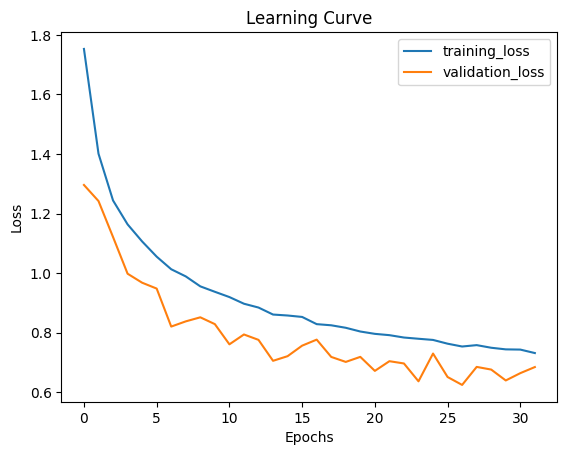

In [ ]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

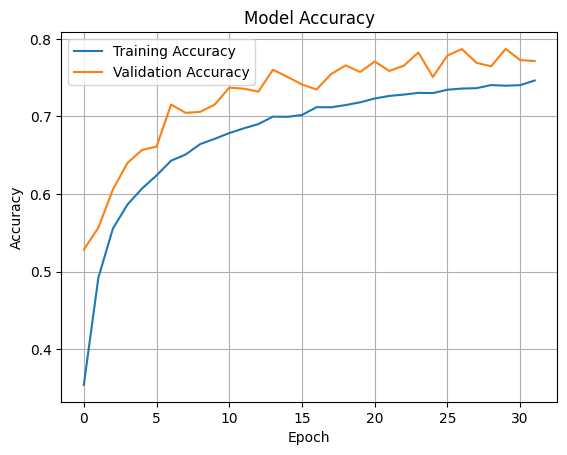

In [ ]:
training_loss = model_history.history['accuracy']
val_loss = model_history.history['val_accuracy']

plt.plot(training_loss, label='Training Accuracy')
plt.plot(val_loss, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

 **Copy model we trained before to Google Drive.**

**Next time, you can use the model we trained before directly for prediction.**

In [ ]:
# 掛載使用者的Google雲端硬碟 (drive/MyDrive) 到 Colab 的工作磁碟
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil

In [ ]:
print(os.listdir(Path.cwd()))

print(Path.cwd())

print(os.listdir(Path.cwd() / 'saved_models'))

print(os.listdir(Path.cwd() / 'drive'))

['.config', 'drive', 'saved_models', 'sample_data']
/content
['keras_cifar10_trained_model.h5']
['MyDrive', '.shortcut-targets-by-id', '.Trash-0', '.Encrypted']


In [ ]:
target_path = Path.cwd() / 'drive' / 'MyDrive' / model_name
source_path = Path.cwd() / 'saved_models' / model_name

shutil.move(source_path, target_path)

PosixPath('/content/drive/MyDrive/keras_cifar10_trained_model.h5')